# Example usage of `hpt` to tune model hyperparameters

In [1]:
import os
import numpy as np

N_SAMPLES = int(10**5)
RANDOM_SEED = 42

rng = np.random.RandomState(RANDOM_SEED)

In [2]:
from sklearn.datasets import make_classification

def generate_data(num_samples, prevalence=0.5, sensitive_prevalence=0.1, random_seed=42):
    
    # Generate features and labels with scikit-learn
    X, Y = make_classification(num_samples, weights=(1-prevalence, prevalence), random_state=random_seed)
    
    # Sensitive attrs
    rng = np.random.RandomState(random_seed)
    S = (rng.random(num_samples) + sensitive_prevalence).astype(int)

    return X, Y, S

In [3]:
X, Y, S = generate_data(num_samples=N_SAMPLES, random_seed=rng.randint(10**10))

In [4]:
# Split train, test
test_size = 0.2

indices = rng.permutation(N_SAMPLES)
test_indices = indices[: int(test_size * N_SAMPLES)]
train_indices = indices[int(test_size * N_SAMPLES): ]

X_train, y_train, s_train = X[train_indices], Y[train_indices], S[train_indices]
X_test, y_test, s_test = X[test_indices], Y[test_indices], S[test_indices]

## Set-up hyperparameter search space

In [5]:
from pathlib import Path
HYPERPARAM_SPACE_PATH = Path() / 'hyperparameter_spaces'
HYPERPARAM_SPACE_PATH = HYPERPARAM_SPACE_PATH / 'sklearn.multiple_algorithms.yaml'

In [6]:
from hpt.tuner import ObjectiveFunction, OptunaTuner

obj_func = ObjectiveFunction(
    X_train, y_train, X_test, y_test,
    hyperparameter_space=HYPERPARAM_SPACE_PATH,
    eval_metric='accuracy',
    s_train=s_train,
    s_val=s_test,
    threshold=0.50,
    alpha=1.0,                             # optimize only performance metric (`eval_metric='accuracy'`)
    other_eval_metric='equalized_odds_diff',   # but still evaluate fairness metric results
)

tuner = OptunaTuner(obj_func) # NOTE: can pass other useful study kwargs here (e.g. storage)

[I 2023-09-05 13:38:51,722] A new study created in memory with name: no-name-b114ffeb-ad7e-4fc9-ac56-d6be007b64be


## Run tuner and plot results

In [7]:
%%time
tuner.optimize(n_trials=50, show_progress_bar=True, n_jobs=os.cpu_count())

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-09-05 13:38:51,852] Trial 0 finished with value: 0.9099 and parameters: {'learner_type': 'LR', 'learner_LR_penalty': 'l2', 'learner_LR_C': 0.01, 'learner_LR_tol': 9.658116684018327e-05, 'learner_LR_max_iter': 145, 'learner_LR_solver': 'liblinear'}. Best is trial 0 with value: 0.9099.
[I 2023-09-05 13:38:51,979] Trial 2 finished with value: 0.89735 and parameters: {'learner_type': 'LR', 'learner_LR_penalty': 'l2', 'learner_LR_C': 1e-05, 'learner_LR_tol': 7.820718867973598e-05, 'learner_LR_max_iter': 78, 'learner_LR_solver': 'liblinear'}. Best is trial 0 with value: 0.9099.
[I 2023-09-05 13:38:52,157] Trial 3 finished with value: 0.9099 and parameters: {'learner_type': 'LR', 'learner_LR_penalty': 'l2', 'learner_LR_C': 0.01, 'learner_LR_tol': 9.977866701242914e-05, 'learner_LR_max_iter': 490, 'learner_LR_solver': 'liblinear'}. Best is trial 0 with value: 0.9099.
[I 2023-09-05 13:38:52,162] Trial 7 finished with value: 0.89735 and parameters: {'learner_type': 'LR', 'learner_LR_pena

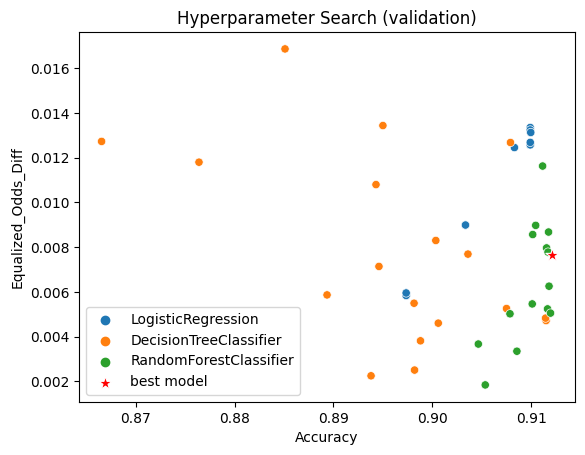

In [9]:
tuner.objective_function.plot(hue="algorithm")

---